# 05. Обучение CNN

## План
1. CIFAR10: baseline
2. Просто добавим аугментаций
3. Pretrained vs from scratch
4. LR scheduling

[Отчёт в Wandb по семинару](https://wandb.ai/dondo_sss/seminar-05-cnn/reports/05-CNN---Vmlldzo1NjcxNjEw?accessToken=l5ihfq2njkfz9ux19ljkdb8fdz1p2wsinu30s7a5tura5l4krf00vwuoab87nsnj)

### 0. Ключ wandb

In [2]:
import wandb

wandb.login(key="YOUR KEY")

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dondo_sss. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/jovyan/.netrc


True

## 1. CIFAR10: baseline

Мы уже умеем составлять несложные архитектуры нейросетей и обучать их на произвольных (картиночных) датасетах.
На этом семинаре мы поговорим о том, какие ручки можно покрутить, чтобы улучшать результаты.

Перечислим некоторые (но точно не все) из таких ручек:

* Параметры модели
  * тип архитектуры
    * семейство (ResNet / EfficientNet / ...)
    * размер модели (ResNet18 / ResNet101?)
  * число обучаемых слоёв
    * warmup при дообучении
  * ...

* Параметры оптимизации
  * собственно оптимизатор (SGD / Adam + вариации / ...)
  * learning rate
    * scheduling
  * momentum
  * weight decay
  * ...
  
* Параметры данных
  * веса классов / сэмплирование
  * набор и сила аугментаций
  * добавление / чистках
  * ...

* Параметры обучения
  * размер батча
  * функция потерь
  * целевая метрика (да, не `val_loss`-ом единым)  
  * критерий остановки
  * ...
  
* ...


Но решение любой задачи начинается с построения бейзлайна!

### 1.1. Получаем данные

In [3]:
import os
import glob
import pickle
import tqdm
import cv2
from torchvision.datasets import CIFAR10

### 1.2. Собираем датасет и знакомимся с данными

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T

Прежде мы при обращении к картинкам через датасет обрабатывали их руками (конвертировали в тензор, например).
Можно (и вообще говоря нужно) делать это через механизм трансформаций:

In [5]:
transforms_simple = T.Compose(
    [T.ToTensor(), T.Normalize([0.5, 0.5, 0.5], [0.25, 0.25, 0.25])]  # по-хорошему нужно брать из датасета
)
# normalized_tensor = (tensor - mean) / std

Здесь мы использовали для трансформаций модуль `torhvision.transforms`, но есть и альтернативы (о них чуть ниже).
Пока что мы ограничились включением в трансформации только базовых операций - конвертации в тензор и нормализации.

In [6]:
dataset_train = CIFAR10("./", train=True, download=False, transform=transforms_simple)

In [7]:
image, label = dataset_train[0]
image.shape, label

(torch.Size([3, 32, 32]), 6)

In [8]:
cifar10_class_map = {idx: idx_class for idx_class, idx in dataset_train.class_to_idx.items()}
cifar10_class_map

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

Для обратной конвертации в картинку (чтобы отрисовать ее, например), нужно сделать "де-нормализацию":

**Задача**: реализовать функцию `tensor_to_image`, получающую на вход нормализованный тензор `(3, h, w)`, возвращающую де-нормализованный массив `(h, w, 3)`.

In [9]:
def tensor_to_image(tensor, mean=(0.5, 0.5, 0.5), std=(0.25, 0.25, 0.25)):
    ### YOUR CODE HERE

    # mean, std ->
    mean = torch.tensor(mean)[:, None, None]
    std = torch.tensor(std)[:, None, None]

    renormalized_tensor = mean + std * tensor
    image = renormalized_tensor.permute(1, 2, 0).detach().cpu().numpy()
    ### END OF YOUR CODE

    return image

In [10]:
image = np.random.uniform(size=(32, 32, 3))
tensor = (torch.from_numpy(image).permute(2, 0, 1) - 0.5) / 0.25

np.testing.assert_array_equal(image, tensor_to_image(tensor))

Посмотрим глазами на данные:

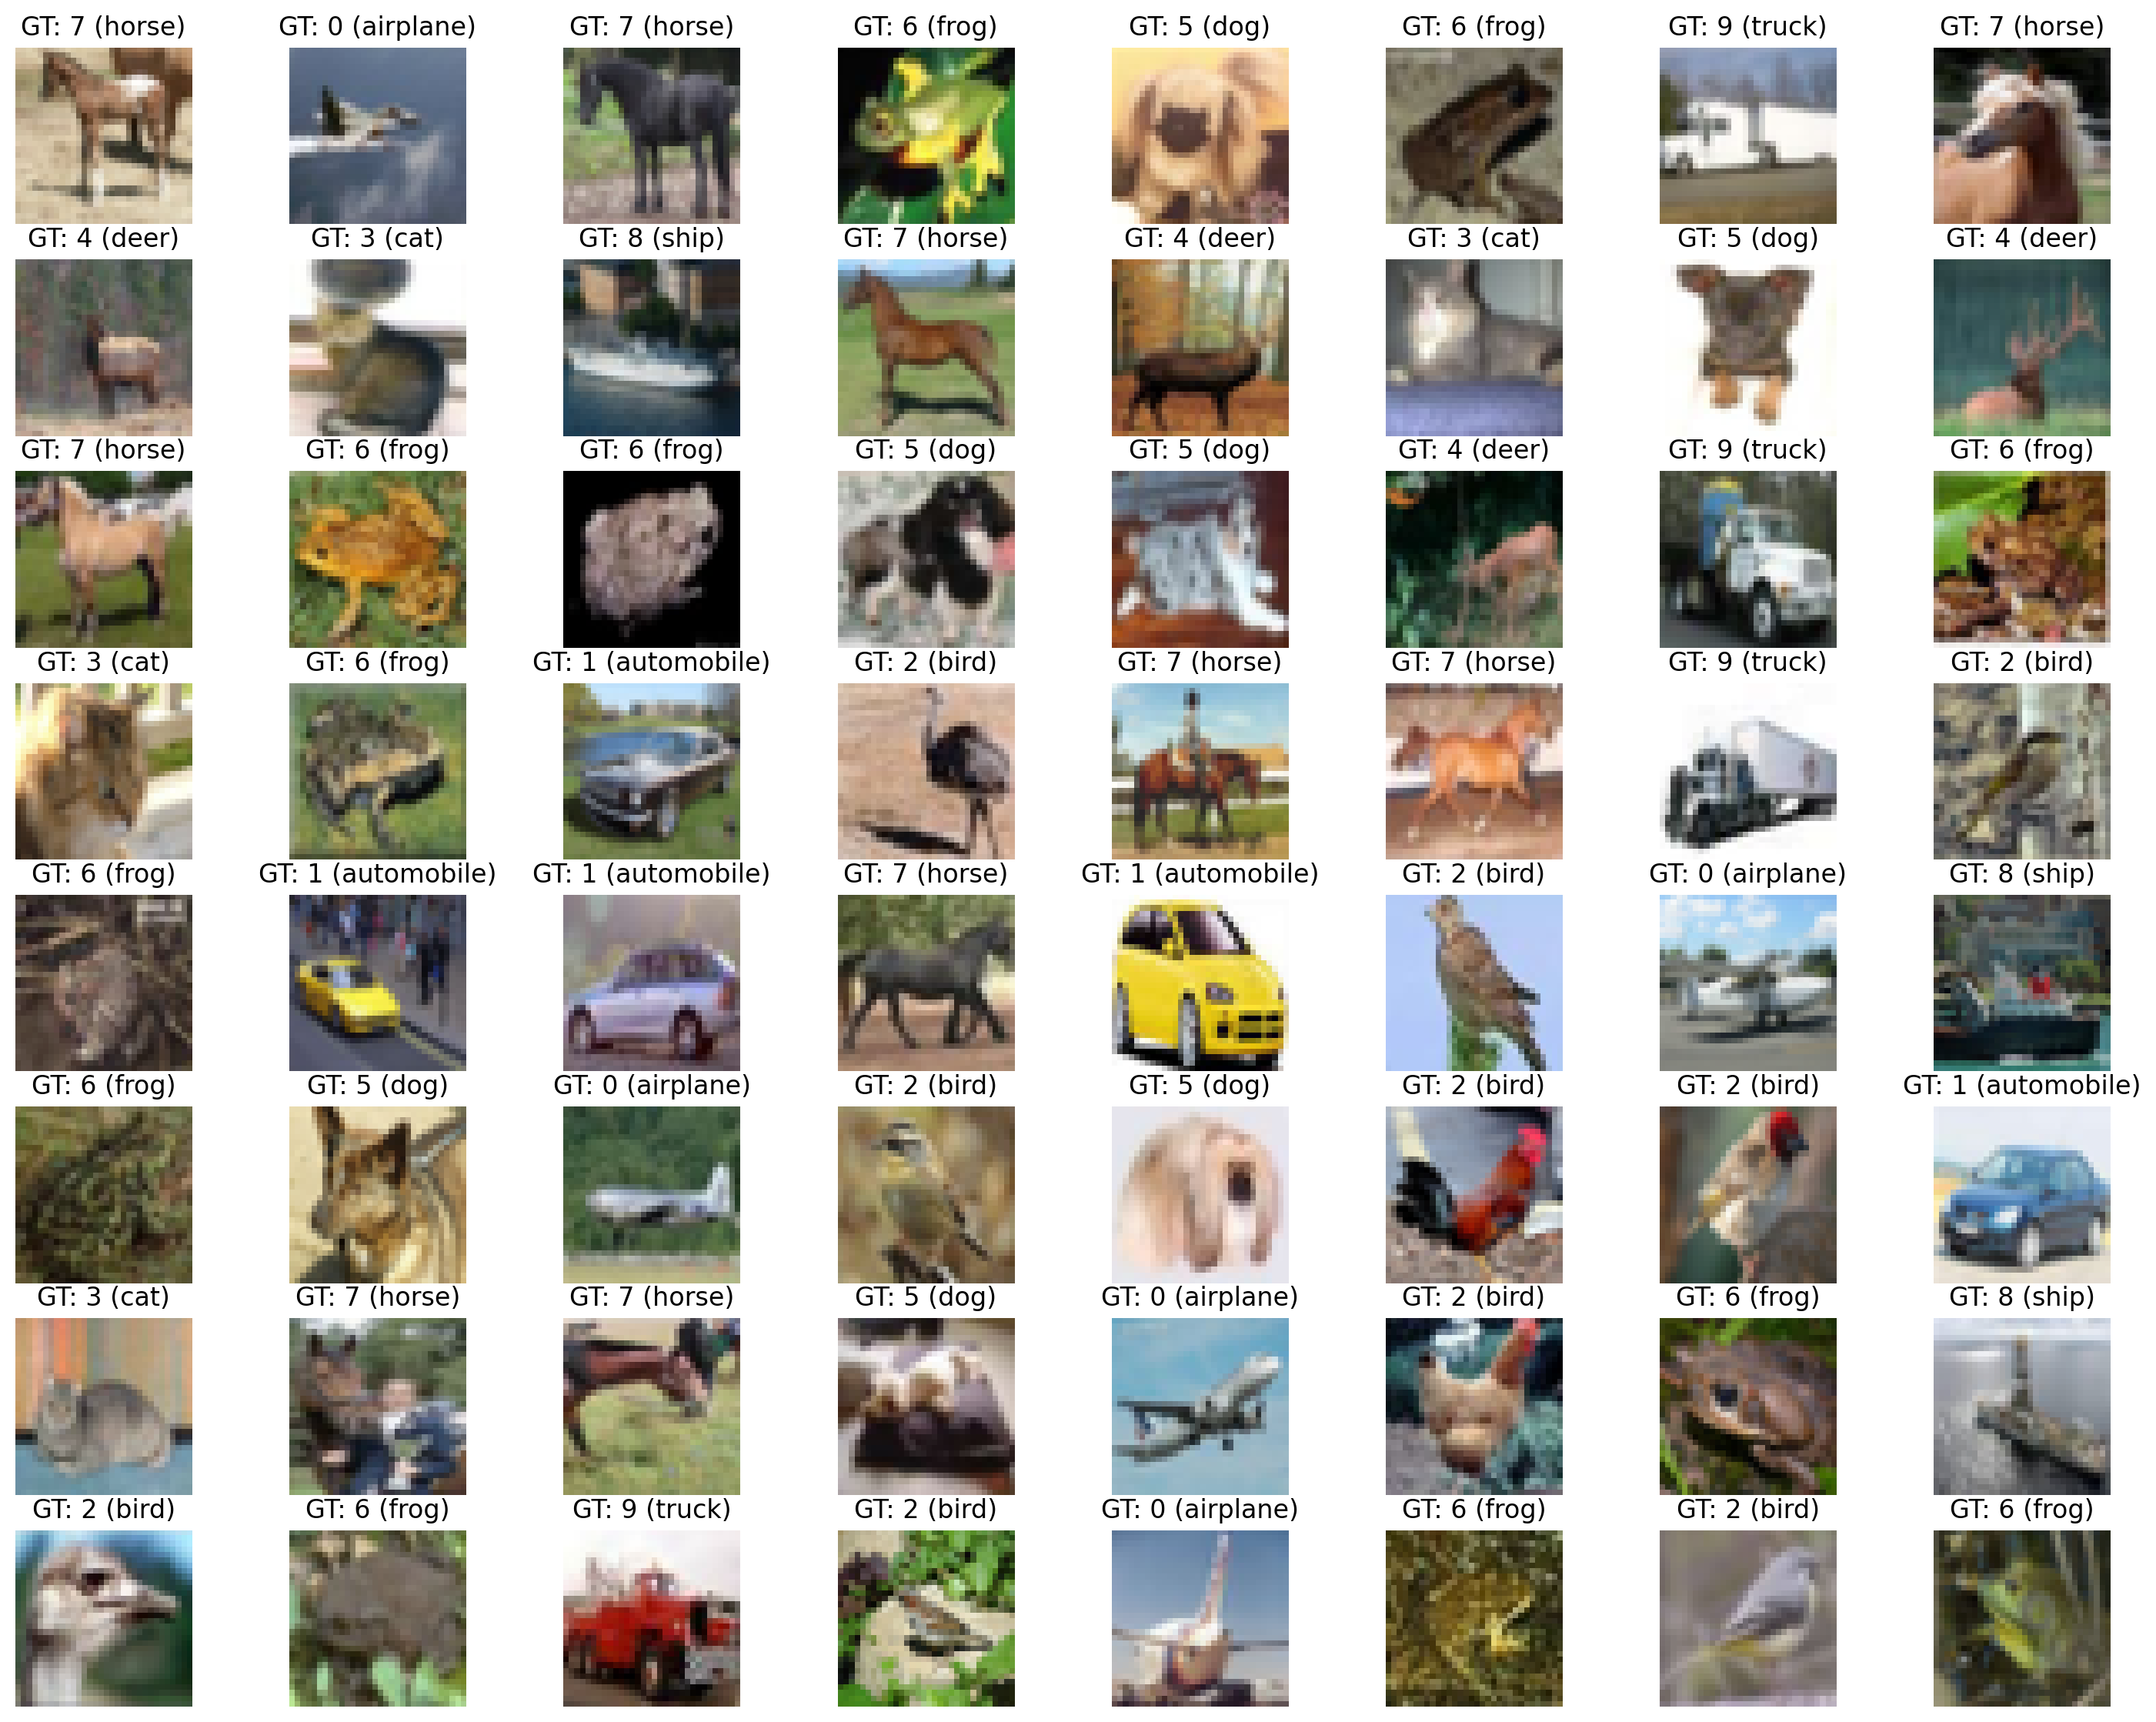

In [11]:
indexes_to_show = np.random.choice(len(dataset_train), size=64, replace=False)

plt.figure(figsize=(18, 14))
for i, index in enumerate(indexes_to_show):
    tensor, label = dataset_train[index]
    image = tensor_to_image(tensor)
    plt.subplot(8, 8, i + 1)
    plt.imshow(image)
    plt.axis(False)
    plt.title(f"GT: {label} ({cifar10_class_map[label]})")
plt.show()

Обычно полезно провести разведывательный анализ данных (EDA).
Сейчас ограничимся тем, что посмотрим на распределение количества картинок по классам.

**Задача**: любым удобным способ вывести количество изображений по каждому классу в обучающем датасете.

In [12]:
labels_train = np.array([label for _, label in dataset_train])

In [14]:
### YOUR CODE HERE
np.unique(labels_train, return_counts=True)
### END OF YOUR CODE

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))

Не забудем собрать валидационный датасет, и двинемся дальше:

In [15]:
dataset_val = CIFAR10("./", train=False, download=False, transform=transforms_simple)

In [16]:
labels_val = np.array([label for _, label in dataset_val])

In [17]:
### YOUR CODE HERE
np.unique(labels_val, return_counts=True)
### END OF YOUR CODE

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

### 1.3. Собираем модель

Начнем, как и собирались, с бейзлайна.
Бейзлайн - это какое-то простое решение, которые конкретно вы можете быстро реализовать и проверить.
Чуть позже бейзлайном вы будете считать уже ResNet34, но пока напишем его ручками.

conv -> bn -> relu -> conv -> bn -> relu (pool)

**Задание**: реализуйте метод для инициализации блока сверточной сети. Блок должен работать так:
* conv 3x3 / in_channels -> out_channels
* batchnorm2d
* relu
* conv 3x3
* batchnorm2d
* relu
* (optionally) maxpool 2x2

In [22]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, pool=True):
        super(CNNBlock, self).__init__()

        ### YOUR CODE HERE
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=False)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(2) if pool else nn.Identity()
        ### END OF YOUR CODE

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        return x

Соберем из этих блоков сеть:

In [23]:
cnn_baseline = nn.Sequential(
    CNNBlock(3, 32),
    CNNBlock(32, 64),
    CNNBlock(64, 128),
    CNNBlock(128, 256),
    CNNBlock(256, 512),
    # v NOTE THIS
    nn.AdaptiveAvgPool2d((1, 1)),  # B x 512 x 1 x 1
    # ^ NOTE THIS ^
    nn.Flatten(),  # B x 512
    nn.Linear(512, 10),
).eval()

In [24]:
x = torch.randn(4, 3, 32, 32)
y = cnn_baseline(x)
y.shape

torch.Size([4, 10])

### 1.4. Учим
#### 1.4.1 Логгирование на примере Wandb

In [25]:
import wandb

config = {
    "learning_rate": 3e-4,
    "weight_decay": 0.05,
    "batch_size": 100,
    "num_epochs": 10,
    "optimizer": torch.optim.AdamW,
}

wandb.init(
    # set the wandb project where this run will be logged
    project="seminar-05-cnn",
    name="baseline",
    reinit=True,
    # track hyperparameters and run metadata
    config=config,
)

In [26]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [27]:
dataloader_train = DataLoader(
    dataset_train,
    batch_size=config["batch_size"],
    shuffle=True,
    drop_last=True,
    num_workers=4,
    pin_memory=True,
)

dataloader_val = DataLoader(
    dataset_val,
    batch_size=config["batch_size"],
    shuffle=False,
    drop_last=False,
    num_workers=4,
    pin_memory=True,
)

Инициализируйте сами необходимый лосс и оптимизатор Adam, взяв готовые из `pytorch`:

In [28]:
### YOUR CODE HERE

# loss_fn = ...
# optimizer = ...

loss_fn = nn.CrossEntropyLoss()
optimizer = config["optimizer"](
    cnn_baseline.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"]
)


### END OF YOUR CODE

Раньше у нас были отдельные методы для обучения/валидации - теперь мы готовы сделать из них один:

In [29]:
def run_epoch(stage, model, dataloader, loss_fn, optimizer, epoch, device):
    # v NOTE THIS v
    if stage == "train":
        model.train()
        torch.set_grad_enabled(True)
    else:
        torch.set_grad_enabled(False)
        model.eval()
    # ^ NOTE THIS ^

    model = model.to(device)

    losses = []
    for batch in tqdm.tqdm(dataloader, total=len(dataloader), desc=f"epoch: {str(epoch).zfill(3)} | {stage:5}"):
        xs, ys_true = batch

        ys_pred = model(xs.to(device))
        loss = loss_fn(ys_pred, ys_true.to(device))

        if stage == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            wandb.log({"lr": optimizer.param_groups[0]["lr"], "loss": loss})

        losses.append(loss.detach().cpu().item())

    return np.mean(losses)

Кроме того, мы готовы к чему-то большему, чем просто брать последний чекпоинт модели.
Будем контролировать значение целевой метрики (сегодня это `val_loss`), и сохранять чекпоинт модели в случае, если он лучший.

Для этого вспомните-ка, как сохранять и загружать веса моделей.

**Задание**: реализуйте функции `save_checkpoint()` & `load_checkpoint()`. На входе объект модели и имя файла, на выходе - ничего (но в случае загрузки модель должна получить новые веса).

In [32]:
def save_checkpoint(model, filename):
    ### YOUR CODE HERE

    with open(filename, "wb") as fp:
        torch.save(model.state_dict(), fp)

    ### END OF YOUR CODE


def load_checkpoint(model, filename):
    ### YOUR CODE HERE

    with open(filename, "rb") as fp:
        state_dict = torch.load(fp, map_location="cpu")
    model.load_state_dict(state_dict)

    ### END OF YOUR CODE

In [33]:
my_model = nn.Linear(100, 1)
my_model.weight.data *= 1e6
save_checkpoint(my_model, "test.pth.tar")

my_model_new = nn.Linear(100, 1)
load_checkpoint(my_model_new, "test.pth.tar")

torch.testing.assert_allclose(my_model.weight, my_model_new.weight)

/tmp/ipykernel_153736/3222267050.py:8: FutureWarning: `torch.testing.assert_allclose()` is deprecated since 1.12 and will be removed in a future release. Please use `torch.testing.assert_close()` instead. You can find detailed upgrade instructions in https://github.com/pytorch/pytorch/issues/61844.
  torch.testing.assert_allclose(my_model.weight, my_model_new.weight)


Экспериментов у нас будет много, поэтому для экономии кода обернем все, что нужно для обучения, в функцию `run_experiment()`:

In [34]:
def run_experiment(
    model, dataloader_train, dataloader_val, loss_fn, optimizer, num_epochs, device, output_dir, start_epoch=0
):
    train_losses = []
    val_losses = []

    best_val_loss = np.inf
    best_val_loss_epoch = -1
    best_val_loss_fn = None

    os.makedirs(output_dir, exist_ok=True)

    for epoch in range(num_epochs):
        train_loss = run_epoch("train", model, dataloader_train, loss_fn, optimizer, epoch, device)
        train_losses.append(train_loss)

        val_loss = run_epoch("val", model, dataloader_val, loss_fn, optimizer, epoch, device)
        val_losses.append(val_loss)

        wandb.log({"epoch_loss_train": train_loss, "epoch_loss_val": val_loss, "epoch": start_epoch + epoch})

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_loss_epoch = epoch

            output_fn = os.path.join(output_dir, f"epoch={str(epoch).zfill(2)}_valloss={best_val_loss:.3f}.pth.tar")
            save_checkpoint(model, output_fn)
            print(f"New checkpoint saved to {output_fn}\n")

            best_val_loss_fn = output_fn

    print(f"Best val_loss = {best_val_loss:.3f} reached at epoch {best_val_loss_epoch}")
    load_checkpoint(model, best_val_loss_fn)

    return train_losses, val_losses, best_val_loss, model

Запустим:

In [35]:
train_losses_baseline, val_losses_baseline, best_val_loss_baseline, cnn_baseline = run_experiment(
    cnn_baseline,
    dataloader_train,
    dataloader_val,
    loss_fn,
    optimizer,
    config["num_epochs"],
    device,
    "checkpoints_baseline",
)

epoch: 000 | train: 100%|██████████| 500/500 [00:09<00:00, 54.56it/s] 
epoch: 000 | val  : 100%|██████████| 100/100 [00:01<00:00, 74.86it/s]


New checkpoint saved to checkpoints_baseline/epoch=00_valloss=0.919.pth.tar



epoch: 001 | train: 100%|██████████| 500/500 [00:05<00:00, 87.65it/s] 
epoch: 001 | val  : 100%|██████████| 100/100 [00:01<00:00, 73.24it/s]


New checkpoint saved to checkpoints_baseline/epoch=01_valloss=0.768.pth.tar



epoch: 002 | train: 100%|██████████| 500/500 [00:05<00:00, 86.69it/s]
epoch: 002 | val  : 100%|██████████| 100/100 [00:01<00:00, 72.53it/s] 
epoch: 003 | train: 100%|██████████| 500/500 [00:05<00:00, 86.60it/s]
epoch: 003 | val  : 100%|██████████| 100/100 [00:01<00:00, 71.96it/s]


New checkpoint saved to checkpoints_baseline/epoch=03_valloss=0.694.pth.tar



epoch: 004 | train: 100%|██████████| 500/500 [00:05<00:00, 87.97it/s] 
epoch: 004 | val  : 100%|██████████| 100/100 [00:01<00:00, 72.68it/s]
epoch: 005 | train: 100%|██████████| 500/500 [00:05<00:00, 86.32it/s] 
epoch: 005 | val  : 100%|██████████| 100/100 [00:01<00:00, 73.12it/s]
epoch: 006 | train: 100%|██████████| 500/500 [00:05<00:00, 88.73it/s] 
epoch: 006 | val  : 100%|██████████| 100/100 [00:01<00:00, 73.44it/s] 
epoch: 007 | train: 100%|██████████| 500/500 [00:05<00:00, 89.76it/s] 
epoch: 007 | val  : 100%|██████████| 100/100 [00:01<00:00, 60.60it/s]
epoch: 008 | train: 100%|██████████| 500/500 [00:05<00:00, 88.11it/s] 
epoch: 008 | val  : 100%|██████████| 100/100 [00:01<00:00, 72.88it/s]
epoch: 009 | train: 100%|██████████| 500/500 [00:05<00:00, 84.08it/s] 
epoch: 009 | val  : 100%|██████████| 100/100 [00:01<00:00, 74.31it/s] 


Best val_loss = 0.694 reached at epoch 3


Смотрим результаты:

In [36]:
def plot_losses(train_losses, val_losses, title):
    plt.figure(figsize=(12, 5))
    plt.title(title)
    plt.plot(train_losses, label="train")
    plt.plot(val_losses, label="val")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.grid(True)
    plt.legend()
    plt.show()

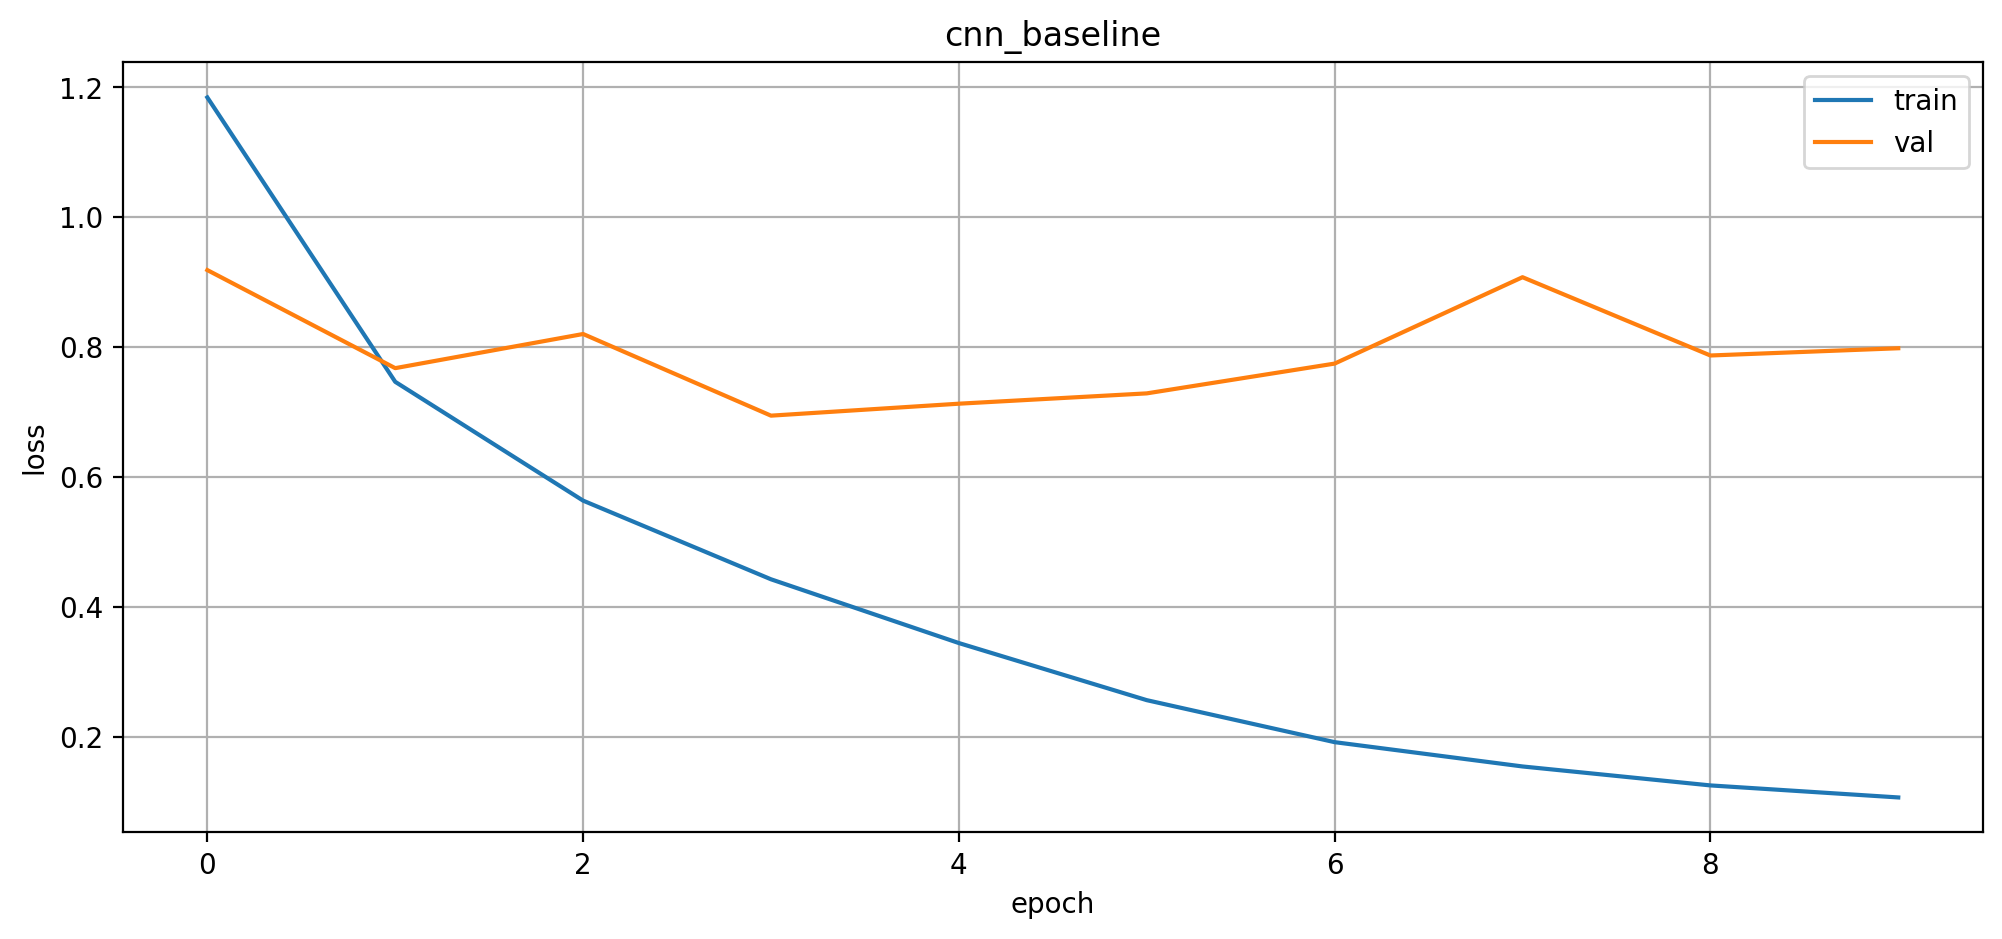

In [37]:
plot_losses(train_losses_baseline, val_losses_baseline, title="cnn_baseline")

Считаем метрики:

In [38]:
def collect_predictions(model, dataloader, device):
    model.eval()
    model = model.to(device)
    torch.set_grad_enabled(False)

    labels_all = []
    probs_all = []
    preds_all = []
    for batch in tqdm.tqdm(dataloader, total=len(dataloader)):
        images, labels = batch

        logits = model(images.to(device)).cpu()
        probs = logits.softmax(dim=1)
        max_prob, max_prob_index = torch.max(probs, dim=1)

        labels_all.extend(labels.numpy().tolist())
        probs_all.extend(max_prob.numpy().tolist())
        preds_all.extend(max_prob_index.numpy().tolist())

    return labels_all, probs_all, preds_all

In [39]:
train_labels, train_probs, train_preds = collect_predictions(cnn_baseline, dataloader_train, device)

accuracy_train = accuracy_score(train_labels, train_preds)
accuracy_train

100%|██████████| 500/500 [00:05<00:00, 98.26it/s] 


0.87458

In [40]:
train_labels[:5], train_preds[:5], train_probs[:5]

([1, 5, 8, 1, 8],
 [1, 5, 8, 1, 8],
 [0.9956496357917786,
  0.9891337752342224,
  0.6327674388885498,
  0.9996746778488159,
  0.8454599380493164])

In [41]:
val_labels, val_probs, val_preds = collect_predictions(cnn_baseline, dataloader_val, device)

accuracy_val = accuracy_score(val_labels, val_preds)
accuracy_val

100%|██████████| 100/100 [00:01<00:00, 70.82it/s]


0.769

In [42]:
val_labels[:5], val_probs[:5], val_preds[:5]

([3, 8, 8, 0, 6],
 [0.912855327129364,
  0.5412553548812866,
  0.48357903957366943,
  0.9764225482940674,
  0.9976813793182373],
 [3, 8, 1, 0, 6])

## 2. Просто добавим аугментаций

Одна из базовых вещей при обучении - это аугментации. Можно делать с помощью `torchvision.transforms`, а можно взять сторонние библиотеки - например, [`albumentations`](https://albumentations.ai/). Есть и [более необычные вещи](https://pytorch.org/vision/main/generated/torchvision.transforms.AutoAugment.html), но о них мы отдельно говорить не будем.

С аугментациями можно переборщить, поэтому начнем с малого:

In [61]:
config["transforms"] = T.Compose(
    [
        T.ToTensor(),
        T.RandomHorizontalFlip(),
        T.RandomRotation(degrees=15),
        T.Normalize([0.5, 0.5, 0.5], [0.25, 0.25, 0.25]),
    ]
)

In [62]:
dataset_aug_train = CIFAR10("./", train=True, download=False, transform=config["transforms"])

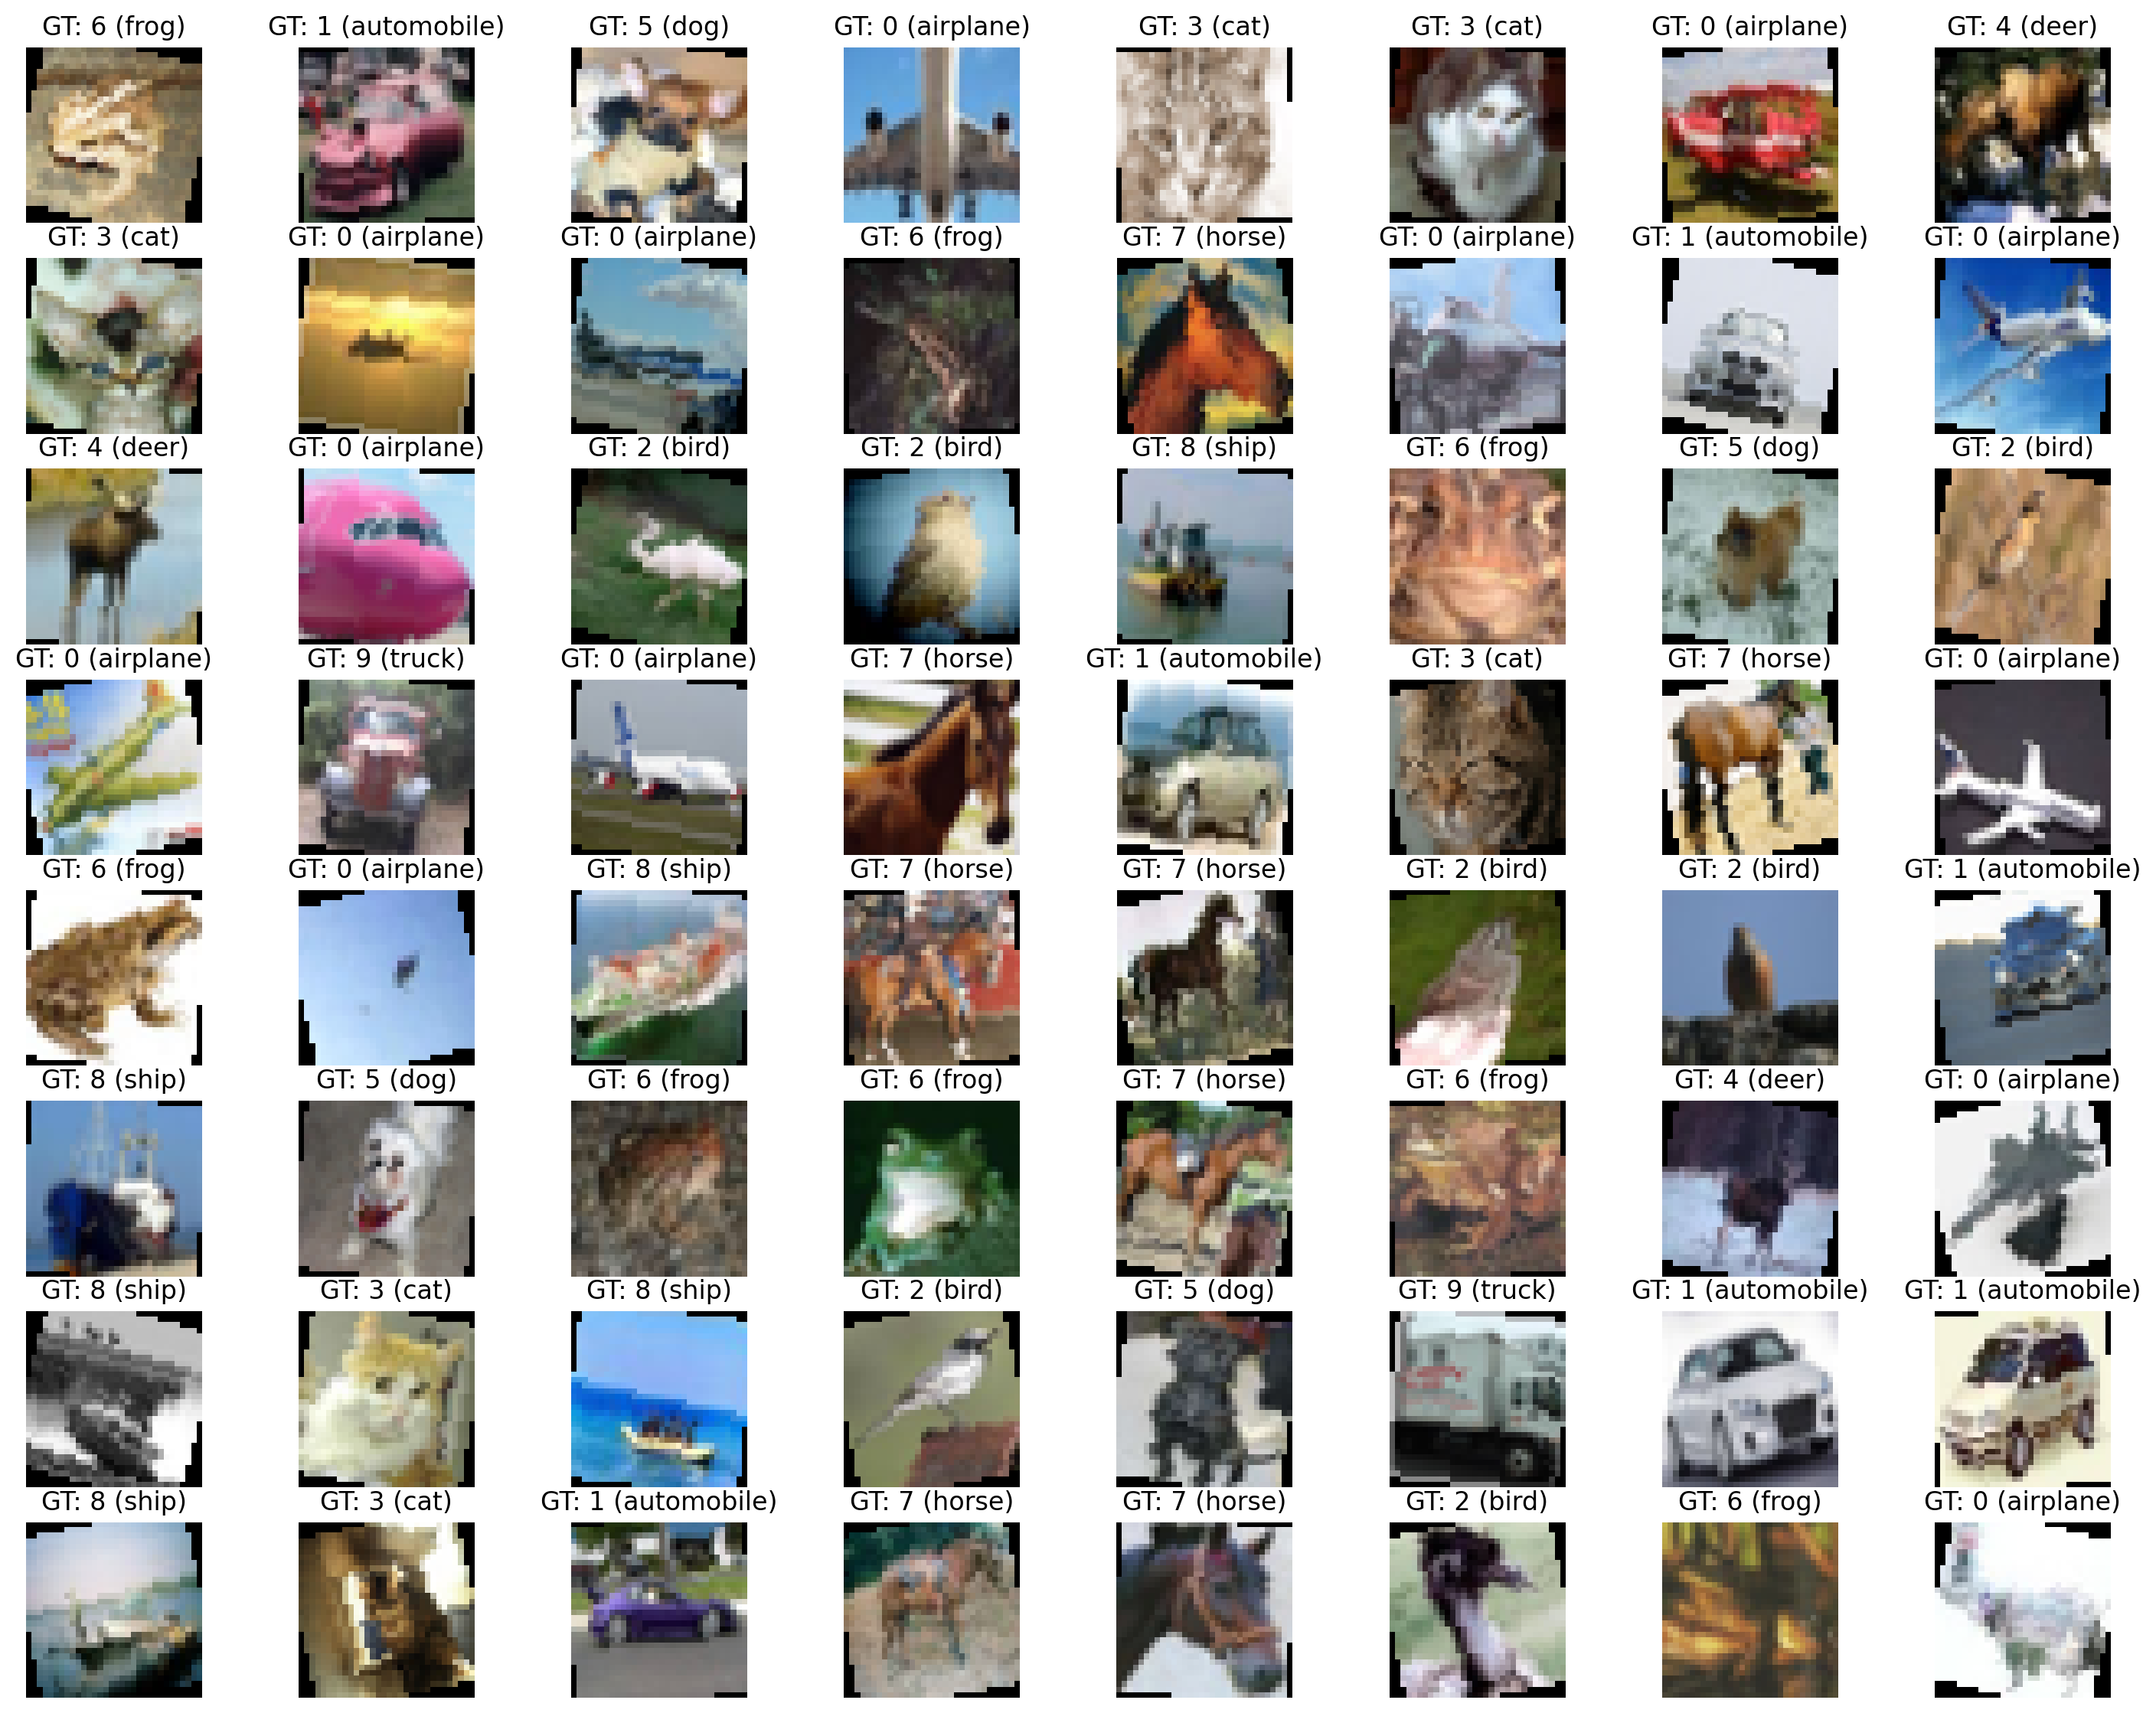

In [63]:
indexes_to_show = np.random.choice(len(dataset_aug_train), size=64, replace=False)

plt.figure(figsize=(18, 14))
for i, index in enumerate(indexes_to_show):
    tensor, label = dataset_aug_train[index]
    image = tensor_to_image(tensor)
    plt.subplot(8, 8, i + 1)
    plt.imshow(image)
    plt.axis(False)
    plt.title(f"GT: {label} ({cifar10_class_map[label]})")
plt.show()

Посмотрим на динамику обучения с аугментациями (обратите внимание, валидационный датасет остался прежним):

In [64]:
cnn_aug = nn.Sequential(
    CNNBlock(3, 32), CNNBlock(32, 64), CNNBlock(64, 128), nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(), nn.Linear(128, 10)
)

Увеличим число эпох (забегая вперед - переобучение мы немного снизим, поэтому имеет смысл добавить итераций).

In [65]:
dataloader_aug_train = DataLoader(
    dataset_aug_train, batch_size=config["batch_size"], shuffle=True, drop_last=True, num_workers=4, pin_memory=True
)

dataloader_val = DataLoader(
    dataset_val, batch_size=config["batch_size"], shuffle=False, drop_last=False, num_workers=4, pin_memory=True
)

In [66]:
loss_fn = nn.CrossEntropyLoss()

optimizer = config["optimizer"](cnn_aug.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])

In [67]:
wandb.finish()

wandb.init(
    # set the wandb project where this run will be logged
    project="seminar-05-cnn",
    name="baseline_augs",
    reinit=True,
    # track hyperparameters and run metadata
    config=config,
)

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▂▃▃▄▅▆▆▇█
epoch_loss_train,█▅▄▃▃▂▂▁▁▁
epoch_loss_val,█▃▅▁▂▂▄█▄▄
loss,█▇▆▅▄▅▅▄▃▃▃▄▃▄▃▄▃▃▂▃▂▂▂▂▁▂▂▁▁▂▂▂▁▁▂▂▁▁▂▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,9
epoch_loss_train,0.10644
epoch_loss_val,0.79827
loss,0.16482
lr,0.0003


In [68]:
train_losses_aug, val_losses_aug, best_val_loss_aug, cnn_aug = run_experiment(
    cnn_aug, dataloader_aug_train, dataloader_val, loss_fn, optimizer, config["num_epochs"], device, "checkpoints_aug"
)

epoch: 000 | train: 100%|██████████| 500/500 [00:13<00:00, 37.29it/s]
epoch: 000 | val  : 100%|██████████| 100/100 [00:01<00:00, 74.04it/s]


New checkpoint saved to checkpoints_aug/epoch=00_valloss=1.151.pth.tar



epoch: 001 | train: 100%|██████████| 500/500 [00:13<00:00, 38.02it/s]
epoch: 001 | val  : 100%|██████████| 100/100 [00:01<00:00, 72.67it/s]


New checkpoint saved to checkpoints_aug/epoch=01_valloss=0.981.pth.tar



epoch: 002 | train: 100%|██████████| 500/500 [00:13<00:00, 37.33it/s]
epoch: 002 | val  : 100%|██████████| 100/100 [00:01<00:00, 76.30it/s]


New checkpoint saved to checkpoints_aug/epoch=02_valloss=0.881.pth.tar



epoch: 003 | train: 100%|██████████| 500/500 [00:13<00:00, 38.03it/s]
epoch: 003 | val  : 100%|██████████| 100/100 [00:01<00:00, 74.73it/s]


New checkpoint saved to checkpoints_aug/epoch=03_valloss=0.772.pth.tar



epoch: 004 | train: 100%|██████████| 500/500 [00:13<00:00, 37.75it/s]
epoch: 004 | val  : 100%|██████████| 100/100 [00:01<00:00, 74.95it/s]


New checkpoint saved to checkpoints_aug/epoch=04_valloss=0.721.pth.tar



epoch: 005 | train: 100%|██████████| 500/500 [00:13<00:00, 37.33it/s]
epoch: 005 | val  : 100%|██████████| 100/100 [00:01<00:00, 73.05it/s] 


New checkpoint saved to checkpoints_aug/epoch=05_valloss=0.656.pth.tar



epoch: 006 | train: 100%|██████████| 500/500 [00:13<00:00, 38.06it/s]
epoch: 006 | val  : 100%|██████████| 100/100 [00:01<00:00, 75.32it/s]


New checkpoint saved to checkpoints_aug/epoch=06_valloss=0.625.pth.tar



epoch: 007 | train: 100%|██████████| 500/500 [00:13<00:00, 37.66it/s]
epoch: 007 | val  : 100%|██████████| 100/100 [00:01<00:00, 73.36it/s]


New checkpoint saved to checkpoints_aug/epoch=07_valloss=0.607.pth.tar



epoch: 008 | train: 100%|██████████| 500/500 [00:13<00:00, 37.21it/s]
epoch: 008 | val  : 100%|██████████| 100/100 [00:01<00:00, 72.68it/s]


New checkpoint saved to checkpoints_aug/epoch=08_valloss=0.581.pth.tar



epoch: 009 | train: 100%|██████████| 500/500 [00:13<00:00, 37.93it/s]
epoch: 009 | val  : 100%|██████████| 100/100 [00:01<00:00, 73.88it/s]

Best val_loss = 0.581 reached at epoch 8


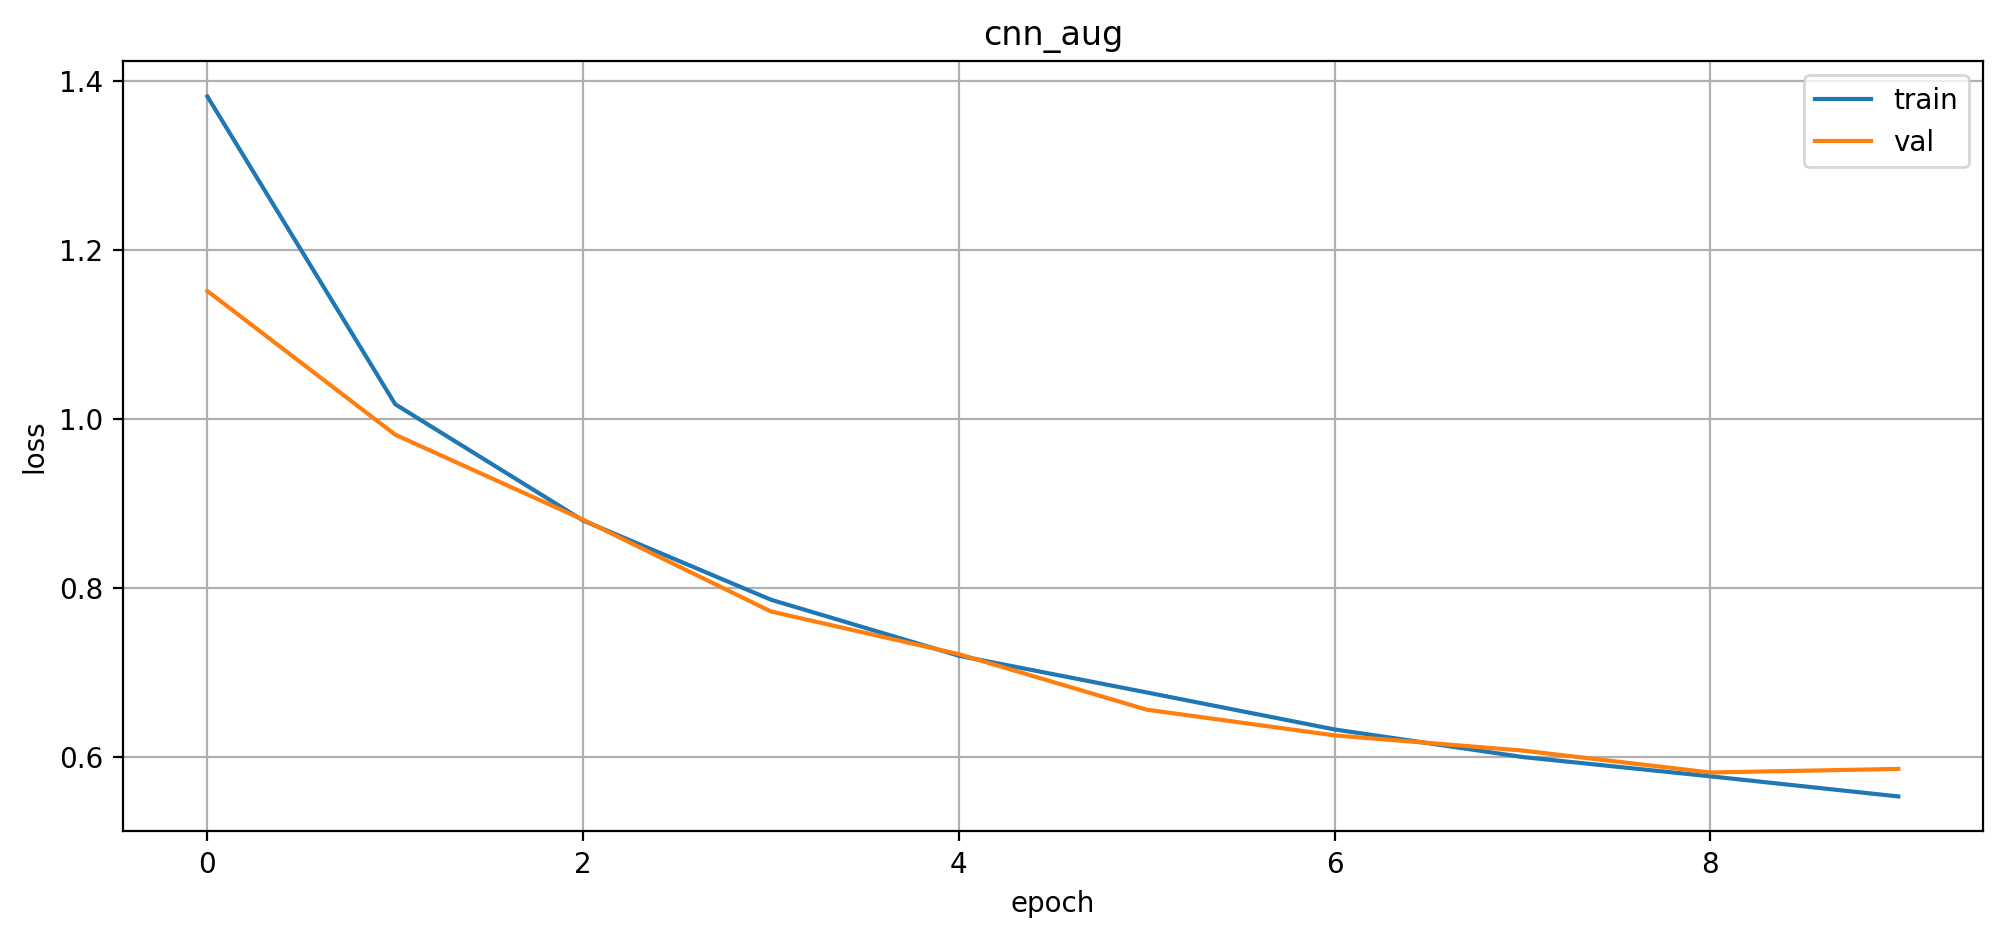

In [69]:
plot_losses(train_losses_aug, val_losses_aug, title="cnn_aug")

In [70]:
train_labels, train_probs, train_preds = collect_predictions(cnn_aug, dataloader_aug_train, device)

accuracy_train = accuracy_score(train_labels, train_preds)
accuracy_train

100%|██████████| 500/500 [00:13<00:00, 38.05it/s]


0.79156

In [71]:
val_labels, val_probs, val_preds = collect_predictions(cnn_aug, dataloader_val, device)

accuracy_val = accuracy_score(val_labels, val_preds)
accuracy_val

100%|██████████| 100/100 [00:01<00:00, 70.14it/s]


0.7986

## 3. Pretrained & from scratch

Важнейший прием, которым следует овладеть - это пользоваться готовыми моделями :)

Часто (*да почти всегда*) лучше учиться не со случайных весов. Если у вас в наличии есть модель, уже обученная на хоть сколько-нибудь смежном домене с целевым - надо брать и дообучаться с нее.

Откуда брать модели?
* [`torchvision.models`](https://pytorch.org/vision/0.8/models.html)
* [`timm`](https://github.com/rwightman/pytorch-image-models)
* [`transformers`](https://github.com/huggingface/transformers)
* ...

In [72]:
from torchvision import models as M

ResNet - база. Возьмем 18-слойный:

![resnet](https://velog.velcdn.com/images%2Fe_sin528%2Fpost%2Fe272c056-3dfa-4bb6-bfc9-b309d82df932%2FResNet18.png)

In [73]:
resnet18 = M.resnet18(pretrained=True)

/home/jovyan/kurkin/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jovyan/kurkin/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [74]:
resnet18.eval();

In [75]:
x = torch.randn(1, 3, 224, 224)

y = resnet18(x)
y.size()

torch.Size([1, 1000])

In [77]:
x = torch.randn(1, 3, 32, 32)

y = resnet18(x)
y.size()

torch.Size([1, 1000])

In [82]:
resnet18.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, bias=False)

In [83]:
x = torch.randn(1, 3, 32, 32)

y = resnet18(x)
y.size()

torch.Size([1, 1000])

In [84]:
resnet18 = M.resnet18(pretrained=True).eval()

/home/jovyan/kurkin/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jovyan/kurkin/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Как использовать готовую модель?
* Заменить выходной слой на слой с нужным числом классов
  * `timm` умеет это прямо при инициализации
* Взять `feature_extractor` модели и навернуть сверху своих слоев
  * `timm` опять же позволяет это легко сделать
  
У нас особенный случай: ResNet18 уменьшает размер входного изображения в 64 раза, а у нас картинки 32х32. Как быть?

In [ ]:
x = torch.randn(1, 3, 32, 32)

y = resnet18(x)
y.size()

Например, можно взять и выдрать слои из модели и поместить в `Sequential`, приправив своими слоями сверху:

In [85]:
cnn_finetuned = nn.Sequential(
    resnet18.conv1,
    resnet18.bn1,
    resnet18.relu,
    resnet18.maxpool,
    resnet18.layer1,
    resnet18.layer2,
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(128, 10),
).eval()

In [86]:
cnn_finetuned(x)

tensor([[-0.1057, -0.3367, -0.4789,  0.3071, -0.2259, -0.1139,  0.4756, -0.1058,
          0.1233,  0.1891]])

Теперь про обучение. Поскольку у нас есть частично обученные веса на входе (из ResNet) и полностью необученные на выходе (свои) веса, градиенты через конец сети могут быть очень шумными. Поэтому есть практика обучения только новых голов в течение пары эпох, а затем полное обучение:

In [87]:
cnn_finetuned[0].weight.requires_grad, cnn_finetuned[-1].weight.requires_grad

(True, True)

Веса слоев можно заморозить ручками:

In [88]:
for layer in cnn_finetuned:
    layer.requires_grad_(False)

In [89]:
cnn_finetuned[0].weight.requires_grad, cnn_finetuned[-1].weight.requires_grad

(False, False)

In [90]:
cnn_finetuned[-1].requires_grad_(True)
cnn_finetuned[-1].weight.requires_grad

True

Теперь к обучению:

In [91]:
loss_fn = nn.CrossEntropyLoss()
optimizer = config["optimizer"](
    cnn_finetuned[-1].parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"]
)

Сначала 3 эпохи учим только последний слой:

In [92]:
wandb.finish()

wandb.init(
    # set the wandb project where this run will be logged
    project="seminar-05-cnn",
    name="resnet",
    reinit=True,
    # track hyperparameters and run metadata
    config=config,
)

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▂▃▃▄▅▆▆▇█
epoch_loss_train,█▅▄▃▂▂▂▁▁▁
epoch_loss_val,█▆▅▃▃▂▂▁▁▁
loss,█▇█▅▅▅▄▄▃▃▄▃▃▃▃▃▃▂▃▃▃▃▂▃▂▁▃▁▁▃▃▂▂▂▁▂▃▁▁▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,9
epoch_loss_train,0.55299
epoch_loss_val,0.58557
loss,0.61995
lr,0.0003


In [93]:
train_losses_finetuned, val_losses_finetuned, best_val_loss_finetuned, cnn_finetuned = run_experiment(
    cnn_finetuned, dataloader_aug_train, dataloader_val, loss_fn, optimizer, 3, device, "checkpoints_finetuned"
)

epoch: 000 | train: 100%|██████████| 500/500 [00:13<00:00, 36.88it/s]
epoch: 000 | val  : 100%|██████████| 100/100 [00:01<00:00, 72.37it/s]


New checkpoint saved to checkpoints_finetuned/epoch=00_valloss=2.121.pth.tar



epoch: 001 | train: 100%|██████████| 500/500 [00:13<00:00, 37.98it/s]
epoch: 001 | val  : 100%|██████████| 100/100 [00:01<00:00, 73.03it/s]


New checkpoint saved to checkpoints_finetuned/epoch=01_valloss=1.981.pth.tar



epoch: 002 | train: 100%|██████████| 500/500 [00:13<00:00, 37.59it/s]
epoch: 002 | val  : 100%|██████████| 100/100 [00:01<00:00, 72.30it/s]


New checkpoint saved to checkpoints_finetuned/epoch=02_valloss=1.866.pth.tar

Best val_loss = 1.866 reached at epoch 2


Теперь размораживаем всю сеть и учим целиком:

In [94]:
for layer in cnn_finetuned:
    layer.requires_grad_(True)


optimizer = config["optimizer"](
    cnn_finetuned.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"]
)

In [95]:
train_losses_finetuned, val_losses_finetuned, best_val_loss_finetuned, cnn_finetuned = run_experiment(
    cnn_finetuned,
    dataloader_aug_train,
    dataloader_val,
    loss_fn,
    optimizer,
    config["num_epochs"] - 3,
    device,
    "checkpoints_finetuned",
    start_epoch=3,
)

epoch: 000 | train: 100%|██████████| 500/500 [00:13<00:00, 37.64it/s]
epoch: 000 | val  : 100%|██████████| 100/100 [00:01<00:00, 73.37it/s]


New checkpoint saved to checkpoints_finetuned/epoch=00_valloss=0.713.pth.tar



epoch: 001 | train: 100%|██████████| 500/500 [00:13<00:00, 36.76it/s]
epoch: 001 | val  : 100%|██████████| 100/100 [00:01<00:00, 72.73it/s] 


New checkpoint saved to checkpoints_finetuned/epoch=01_valloss=0.638.pth.tar



epoch: 002 | train: 100%|██████████| 500/500 [00:13<00:00, 37.94it/s]
epoch: 002 | val  : 100%|██████████| 100/100 [00:01<00:00, 71.76it/s] 


New checkpoint saved to checkpoints_finetuned/epoch=02_valloss=0.568.pth.tar



epoch: 003 | train: 100%|██████████| 500/500 [00:13<00:00, 37.73it/s]
epoch: 003 | val  : 100%|██████████| 100/100 [00:01<00:00, 72.53it/s]


New checkpoint saved to checkpoints_finetuned/epoch=03_valloss=0.537.pth.tar



epoch: 004 | train: 100%|██████████| 500/500 [00:13<00:00, 37.03it/s]
epoch: 004 | val  : 100%|██████████| 100/100 [00:01<00:00, 71.51it/s]


New checkpoint saved to checkpoints_finetuned/epoch=04_valloss=0.511.pth.tar



epoch: 005 | train: 100%|██████████| 500/500 [00:13<00:00, 37.74it/s]
epoch: 005 | val  : 100%|██████████| 100/100 [00:01<00:00, 67.94it/s]
epoch: 006 | train: 100%|██████████| 500/500 [00:13<00:00, 37.68it/s]
epoch: 006 | val  : 100%|██████████| 100/100 [00:01<00:00, 72.06it/s]


New checkpoint saved to checkpoints_finetuned/epoch=06_valloss=0.492.pth.tar

Best val_loss = 0.492 reached at epoch 6


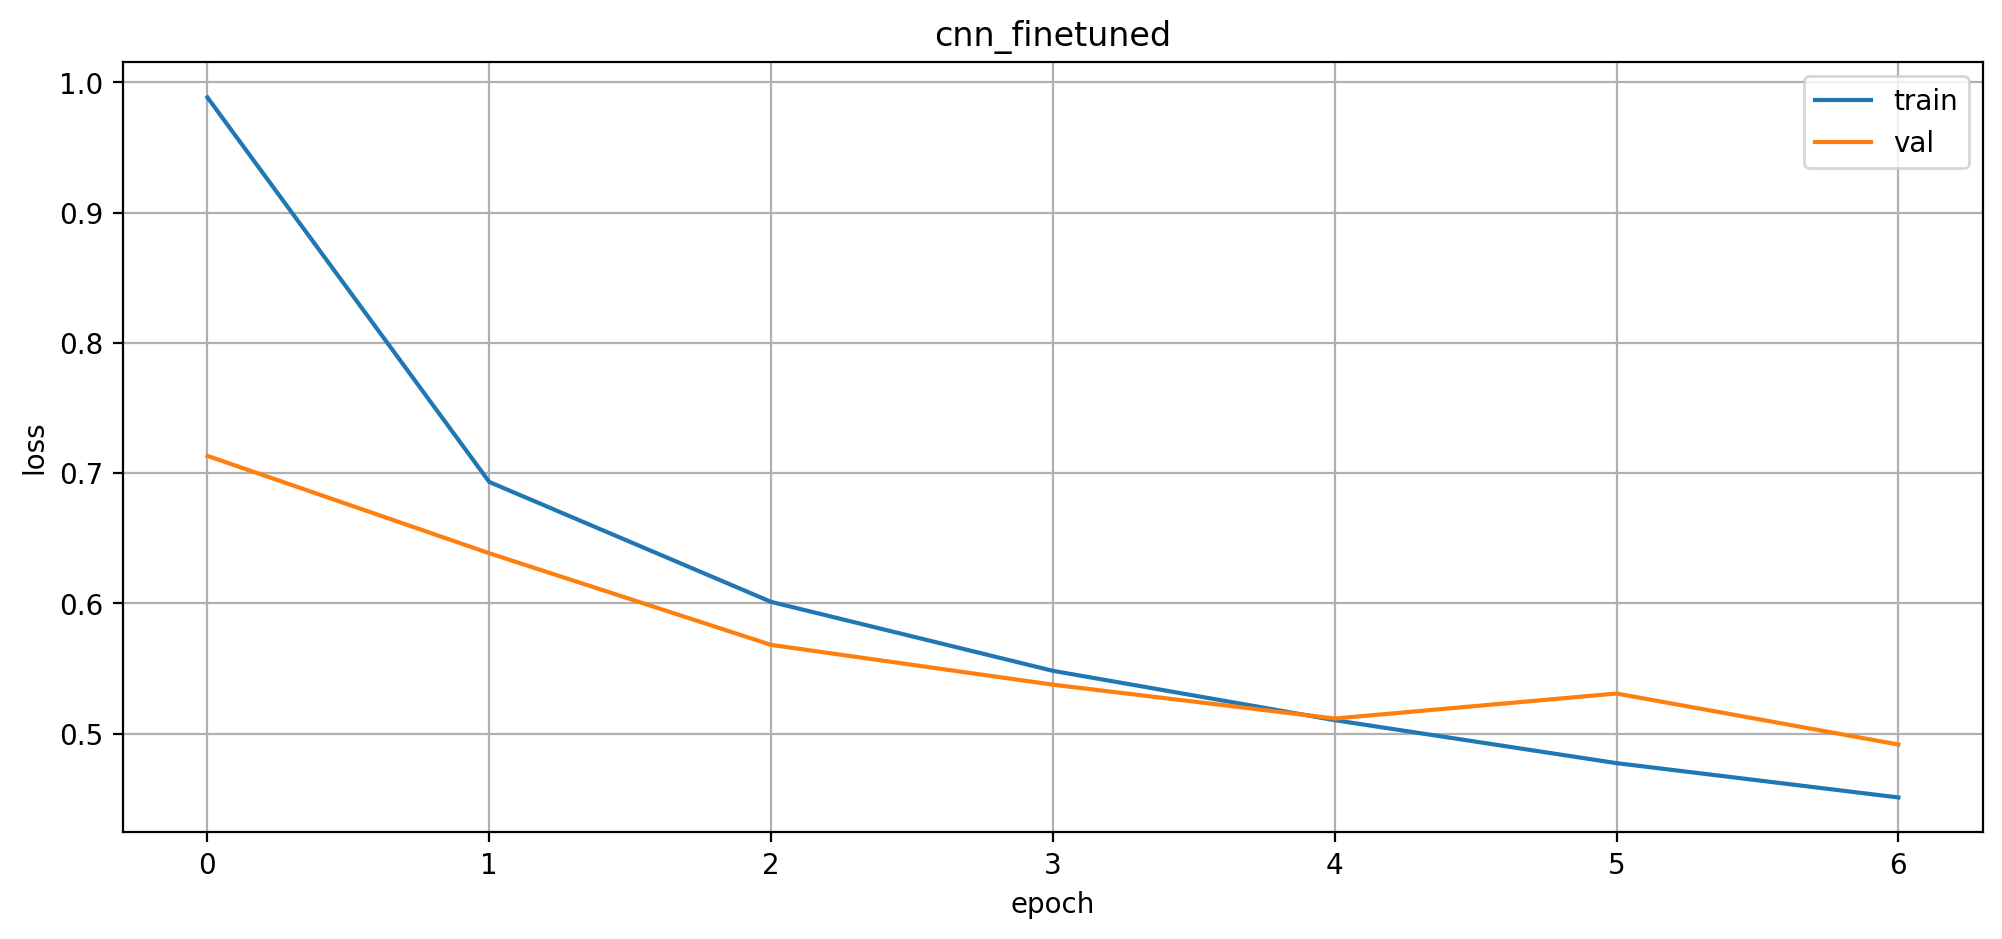

In [96]:
plot_losses(train_losses_finetuned, val_losses_finetuned, title="cnn_finetuned")

In [97]:
train_labels, train_probs, train_preds = collect_predictions(cnn_finetuned, dataloader_aug_train, device)

accuracy_train = accuracy_score(train_labels, train_preds)
accuracy_train

100%|██████████| 500/500 [00:13<00:00, 37.17it/s]


0.85768

In [98]:
val_labels, val_probs, val_preds = collect_predictions(cnn_finetuned, dataloader_val, device)

accuracy_val = accuracy_score(val_labels, val_preds)
accuracy_val

100%|██████████| 100/100 [00:01<00:00, 69.29it/s]


0.8347

## 4. LR scheduling

Последняя на сегодня - работа с LR.
Из лекций вы могли запомнить, что варьирование LR при обучении (даже адаптивных методов) может достичь более высокого качества.

![lrs](https://i.stack.imgur.com/UHYMw.png)

`pytorch` предоставляет возможности и для этого.

### 4.1. Обновление по сигналу от метрик (ReduceLROnPlateau)

Можно изменять LR, основываясь на изменении целевой метрики.
Если, например, лосс давно не падает, можно уменьшить LR:

In [118]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [119]:
cnn_aug = nn.Sequential(
    CNNBlock(3, 32), CNNBlock(32, 64), CNNBlock(64, 128), nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(), nn.Linear(128, 10)
)

In [120]:
loss_fn = nn.CrossEntropyLoss()
config["learning_rate"] = 1.5

optimizer = torch.optim.Adam(cnn_aug.parameters(), lr=config["learning_rate"])

scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=2, verbose=True)

In [102]:
wandb.finish()

wandb.init(
    # set the wandb project where this run will be logged
    project="seminar-05-cnn",
    name="lr_reduce",
    reinit=True,
    # track hyperparameters and run metadata
    config=config,
)

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▂▃▃▄▅▆▆▇█
epoch_loss_train,█▇▇▃▂▂▁▁▁▁
epoch_loss_val,█▇▇▂▂▁▁▁▁▁
loss,█████▇▇▇▇▇▇▇▅▃▄▂▂▂▃▁▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,9
epoch_loss_train,0.4509
epoch_loss_val,0.49154
loss,0.34615
lr,0.0003


In [103]:
def run_epoch(stage, model, dataloader, loss_fn, optimizer, epoch, device):
    if stage == "train":
        model.train()
        torch.set_grad_enabled(True)
    else:
        torch.set_grad_enabled(False)
        model.eval()

    model = model.to(device)

    losses = []
    for batch in tqdm.tqdm(dataloader, total=len(dataloader), desc=f"epoch: {str(epoch).zfill(3)} | {stage:5}"):
        xs, ys_true = batch

        ys_pred = model(xs.to(device))
        loss = loss_fn(ys_pred, ys_true.to(device))

        if stage == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            wandb.log({"lr": optimizer.param_groups[0]["lr"], "loss": loss})

        losses.append(loss.detach().cpu().item())

    if stage == "train":
        scheduler.step(np.mean(losses))

    return np.mean(losses)

In [104]:
train_losses_aug, val_losses_aug, best_val_loss_aug, cnn_aug = run_experiment(
    cnn_aug, dataloader_aug_train, dataloader_val, loss_fn, optimizer, config["num_epochs"], device, "checkpoints_aug"
)

epoch: 000 | train: 100%|██████████| 500/500 [00:13<00:00, 37.60it/s]
epoch: 000 | val  : 100%|██████████| 100/100 [00:01<00:00, 74.04it/s] 


New checkpoint saved to checkpoints_aug/epoch=00_valloss=2.387.pth.tar



epoch: 001 | train: 100%|██████████| 500/500 [00:13<00:00, 37.13it/s]
epoch: 001 | val  : 100%|██████████| 100/100 [00:01<00:00, 73.16it/s]
epoch: 002 | train: 100%|██████████| 500/500 [00:13<00:00, 37.77it/s]
epoch: 002 | val  : 100%|██████████| 100/100 [00:01<00:00, 71.59it/s]


New checkpoint saved to checkpoints_aug/epoch=02_valloss=2.346.pth.tar



epoch: 003 | train: 100%|██████████| 500/500 [00:13<00:00, 37.54it/s]
epoch: 003 | val  : 100%|██████████| 100/100 [00:01<00:00, 71.90it/s]
epoch: 004 | train: 100%|██████████| 500/500 [00:13<00:00, 37.00it/s]
epoch: 004 | val  : 100%|██████████| 100/100 [00:01<00:00, 72.92it/s]


New checkpoint saved to checkpoints_aug/epoch=04_valloss=2.333.pth.tar



epoch: 005 | train: 100%|██████████| 500/500 [00:13<00:00, 37.20it/s]
epoch: 005 | val  : 100%|██████████| 100/100 [00:01<00:00, 71.39it/s]
epoch: 006 | train: 100%|██████████| 500/500 [00:13<00:00, 37.82it/s]
epoch: 006 | val  : 100%|██████████| 100/100 [00:01<00:00, 73.46it/s]
epoch: 007 | train: 100%|██████████| 500/500 [00:13<00:00, 37.08it/s]


Epoch 00008: reducing learning rate of group 0 to 1.5000e-01.


epoch: 007 | val  : 100%|██████████| 100/100 [00:01<00:00, 76.08it/s]
epoch: 008 | train: 100%|██████████| 500/500 [00:13<00:00, 37.93it/s]
epoch: 008 | val  : 100%|██████████| 100/100 [00:01<00:00, 73.11it/s]


New checkpoint saved to checkpoints_aug/epoch=08_valloss=2.313.pth.tar



epoch: 009 | train: 100%|██████████| 500/500 [00:13<00:00, 37.73it/s]
epoch: 009 | val  : 100%|██████████| 100/100 [00:01<00:00, 71.77it/s] 


New checkpoint saved to checkpoints_aug/epoch=09_valloss=2.313.pth.tar

Best val_loss = 2.313 reached at epoch 9


### 4.2. Обновление каждую эпоху (StepLR)

In [105]:
from torch.optim.lr_scheduler import StepLR

In [106]:
cnn_aug = nn.Sequential(
    CNNBlock(3, 32), CNNBlock(32, 64), CNNBlock(64, 128), nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(), nn.Linear(128, 10)
)

In [107]:
loss_fn = nn.CrossEntropyLoss()
config["learning_rate"] = 3e-4
config["num_epochs"] = 5

optimizer = torch.optim.Adam(cnn_aug.parameters(), lr=config["learning_rate"])

scheduler = StepLR(optimizer, step_size=2, gamma=0.1, verbose=True)

Adjusting learning rate of group 0 to 3.0000e-04.


In [108]:
wandb.finish()

wandb.init(
    # set the wandb project where this run will be logged
    project="seminar-05-cnn",
    name="lr_step",
    reinit=True,
    # track hyperparameters and run metadata
    config=config,
)

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▂▃▃▄▅▆▆▇█
epoch_loss_train,█▂▂▂▂▂▂▂▁▁
epoch_loss_val,▇█▄█▃█▅▇▁▁
loss,▄▄▆▃▃▂▂▃▇▃▆▄▂█▆▂▆▆▂▆▃▃▃▇▅▅▂▃█▆▂▇▁▂▁▂▂▁▂▂
lr,████████████████████████████████▁▁▁▁▁▁▁▁
epoch,9
epoch_loss_train,2.31149
epoch_loss_val,2.31319
loss,2.32278
lr,0.15


In [109]:
def run_epoch(stage, model, dataloader, loss_fn, optimizer, epoch, device):
    if stage == "train":
        model.train()
        torch.set_grad_enabled(True)
    else:
        torch.set_grad_enabled(False)
        model.eval()

    model = model.to(device)

    losses = []
    for batch in tqdm.tqdm(dataloader, total=len(dataloader), desc=f"epoch: {str(epoch).zfill(3)} | {stage:5}"):
        xs, ys_true = batch

        ys_pred = model(xs.to(device))
        loss = loss_fn(ys_pred, ys_true.to(device))

        if stage == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            wandb.log({"lr": optimizer.param_groups[0]["lr"], "loss": loss})

        losses.append(loss.detach().cpu().item())

    if stage == "train":
        scheduler.step()

    return np.mean(losses)

In [110]:
train_losses_aug, val_losses_aug, best_val_loss_aug, cnn_aug = run_experiment(
    cnn_aug, dataloader_aug_train, dataloader_val, loss_fn, optimizer, config["num_epochs"], device, "checkpoints_aug"
)

epoch: 000 | train: 100%|██████████| 500/500 [00:13<00:00, 37.51it/s]


Adjusting learning rate of group 0 to 3.0000e-04.


epoch: 000 | val  : 100%|██████████| 100/100 [00:01<00:00, 70.03it/s]


New checkpoint saved to checkpoints_aug/epoch=00_valloss=1.132.pth.tar



epoch: 001 | train: 100%|██████████| 500/500 [00:13<00:00, 37.71it/s]


Adjusting learning rate of group 0 to 3.0000e-05.


epoch: 001 | val  : 100%|██████████| 100/100 [00:01<00:00, 71.23it/s]


New checkpoint saved to checkpoints_aug/epoch=01_valloss=0.944.pth.tar



epoch: 002 | train: 100%|██████████| 500/500 [00:13<00:00, 36.62it/s]


Adjusting learning rate of group 0 to 3.0000e-05.


epoch: 002 | val  : 100%|██████████| 100/100 [00:01<00:00, 73.51it/s]


New checkpoint saved to checkpoints_aug/epoch=02_valloss=0.798.pth.tar



epoch: 003 | train: 100%|██████████| 500/500 [00:13<00:00, 37.76it/s]


Adjusting learning rate of group 0 to 3.0000e-06.


epoch: 003 | val  : 100%|██████████| 100/100 [00:01<00:00, 74.28it/s] 


New checkpoint saved to checkpoints_aug/epoch=03_valloss=0.778.pth.tar



epoch: 004 | train: 100%|██████████| 500/500 [00:13<00:00, 37.93it/s]


Adjusting learning rate of group 0 to 3.0000e-06.


epoch: 004 | val  : 100%|██████████| 100/100 [00:01<00:00, 71.77it/s]

New checkpoint saved to checkpoints_aug/epoch=04_valloss=0.770.pth.tar

Best val_loss = 0.770 reached at epoch 4


### 4.3. Обновление каждую итерацию (CosineAnnealingLR)

Есть разные техники изменения LR по заданному закону. 
Например, [CosineAnnealing](https://paperswithcode.com/method/cosine-annealing).

In [111]:
from torch.optim.lr_scheduler import CosineAnnealingLR

In [112]:
cnn_aug = nn.Sequential(
    CNNBlock(3, 32), CNNBlock(32, 64), CNNBlock(64, 128), nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(), nn.Linear(128, 10)
)

In [113]:
loss_fn = nn.CrossEntropyLoss()
config["learning_rate"] = 3e-4
config["num_epochs"] = 5

optimizer = torch.optim.Adam(cnn_aug.parameters(), lr=config["learning_rate"])

scheduler = CosineAnnealingLR(optimizer, T_max=int(len(dataloader_aug_train) + 1) * config["num_epochs"])

In [114]:
wandb.finish()

wandb.init(
    # set the wandb project where this run will be logged
    project="seminar-05-cnn",
    name="lr_cosine",
    reinit=True,
    # track hyperparameters and run metadata
    config=config,
)

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▃▅▆█
epoch_loss_train,█▄▂▁▁
epoch_loss_val,█▄▂▁▁
loss,█▇▅▅▅▅▃▃▄▃▂▄▂▂▃▃▂▂▂▂▂▁▁▂▁▂▃▂▂▃▁▂▂▁▂▂▂▁▁▁
lr,████████████████▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch,4
epoch_loss_train,0.80106
epoch_loss_val,0.77046
loss,0.96734
lr,0.0


In [115]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(cnn_aug.parameters(), lr=config["learning_rate"])

scheduler = CosineAnnealingLR(optimizer, T_max=int(len(dataloader_aug_train) + 1) * config["num_epochs"])

In [116]:
def run_epoch(stage, model, dataloader, loss_fn, optimizer, epoch, device):
    if stage == "train":
        model.train()
        torch.set_grad_enabled(True)
    else:
        torch.set_grad_enabled(False)
        model.eval()

    model = model.to(device)

    losses = []
    for batch in tqdm.tqdm(dataloader, total=len(dataloader), desc=f"epoch: {str(epoch).zfill(3)} | {stage:5}"):
        xs, ys_true = batch

        ys_pred = model(xs.to(device))
        loss = loss_fn(ys_pred, ys_true.to(device))

        if stage == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
            wandb.log({"lr": optimizer.param_groups[0]["lr"], "loss": loss})

        losses.append(loss.detach().cpu().item())

    return np.mean(losses)

In [117]:
train_losses_aug, val_losses_aug, best_val_loss_aug, cnn_aug = run_experiment(
    cnn_aug, dataloader_aug_train, dataloader_val, loss_fn, optimizer, config["num_epochs"], device, "checkpoints_aug"
)

epoch: 000 | train: 100%|██████████| 500/500 [00:13<00:00, 37.68it/s]
epoch: 000 | val  : 100%|██████████| 100/100 [00:01<00:00, 57.84it/s]


New checkpoint saved to checkpoints_aug/epoch=00_valloss=1.120.pth.tar



epoch: 001 | train: 100%|██████████| 500/500 [00:13<00:00, 37.36it/s]
epoch: 001 | val  : 100%|██████████| 100/100 [00:01<00:00, 69.98it/s]


New checkpoint saved to checkpoints_aug/epoch=01_valloss=0.912.pth.tar



epoch: 002 | train: 100%|██████████| 500/500 [00:13<00:00, 36.95it/s]
epoch: 002 | val  : 100%|██████████| 100/100 [00:01<00:00, 74.29it/s]


New checkpoint saved to checkpoints_aug/epoch=02_valloss=0.818.pth.tar



epoch: 003 | train: 100%|██████████| 500/500 [00:13<00:00, 37.78it/s]
epoch: 003 | val  : 100%|██████████| 100/100 [00:01<00:00, 71.95it/s] 


New checkpoint saved to checkpoints_aug/epoch=03_valloss=0.750.pth.tar



epoch: 004 | train: 100%|██████████| 500/500 [00:13<00:00, 37.45it/s]
epoch: 004 | val  : 100%|██████████| 100/100 [00:01<00:00, 70.75it/s]

New checkpoint saved to checkpoints_aug/epoch=04_valloss=0.736.pth.tar

Best val_loss = 0.736 reached at epoch 4


## Итоги

* Научились добавлять аугментации к обучению
* Познакомились с методом использования предобученных моделей
* Посмотрели на работу с LR scheduling в pytorch.

Рекомендуется (в который раз) почитать пост от любимого нашего Andrej Karpathy [A Recipe for Training Neural Networks](https://karpathy.github.io/2019/04/25/recipe/) и обзорную статью (не самую новую, но все же) по трюкам для обучения моделей [Bag of Tricks for Image Classification with Convolutional Neural Networks](https://arxiv.org/pdf/1812.01187v2.pdf), а также поглядывать при планировании экспериментов в [гайд от Google](https://github.com/google-research/tuning_playbook).

Впереди ждет соревнование по классификации картинок на Kaggle, где вы сможете применить все полученные (и неполученные %)) знания на практике!

In [121]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▃▅▆█
epoch_loss_train,█▄▂▁▁
epoch_loss_val,█▄▃▁▁
loss,██▆▅▆▅▆▃▄▃▄▄▄▃▃▃▃▃▄▃▃▄▃▃▄▃▂▃▂▂▂▃▂▃▃▂▃▁▂▂
lr,███████▇▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
epoch,4
epoch_loss_train,0.76877
epoch_loss_val,0.73562
loss,0.5949
lr,0.0
